<a href="https://www.kaggle.com/code/vikramsandu/dl-nlp-commonlit-summaries?scriptVersionId=141167394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Goal

* The immediate goal is to setup this notebook for training, Inference and submission for LB evaluation. <font color="green">&#10004;</font>
* Efficient Back Translation of the Data for Augmentations. <font color="green">&#10004;</font> [Notebook Link](https://www.kaggle.com/code/vikramsandu/dl-nlp-commonlit-summaries)
* First Finetune the MLM Model on the CommonLit Dataset and then use it for the downstream task. <font color="green">&#10004;</font>  [Notebook Link](https://www.kaggle.com/code/vikramsandu/commonlit-mlm)


Let's Create a Controller variable for Training/Submission Mode.

* Set **True** for Submission Mode.
* Set **False** for Training Mode.

In [2]:
# True if you want to submit the Notebook
isSubmit = False

if isSubmit:
    print(f'This notebook is on submission Mode...')
    print(f'Make sure to turn off the Internet...')
else:
    print(f'This notebook is on Training Mode...')

This notebook is on Training Mode...


## Read and Understand Data.

Here we have two type of files: 
1. **<span style="color:red">Prompts:</span>** It contains the Question, a title about the text, and the text that needs to be summarized.
2. **<span style="color:red">Summaries:</span>** This includes the text summarized by the students, along with the corresponding prompt id and target scores for both content and wording.

In [3]:
# Read Dataset
import pandas as pd

if not isSubmit:
    # Train
    prompt_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
    summary_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')

    print(f'\nLength of Train Prompt df: {len(prompt_df)}')
    print(f'Length of Train Summary df: {len(summary_df)}\n')

    # Display
    display(summary_df.sample(5))


Length of Train Prompt df: 4
Length of Train Summary df: 7165



,student_id,prompt_id,text,content,wording
498,12e87dcee601,39c16e,Three Elements that are ideal for the perfect ...,0.205683,0.380538
5271,baeaad549844,814d6b,Unable to explain to students how people follo...,0.233385,-0.838378
6335,e29cfbfad6fb,3b9047,The ancient of the goverment remoted to many d...,-1.408180,-0.493603
6218,de1a384c805d,ebad26,They would use chemicals to get rid of the odo...,0.014081,-0.124906
4322,99109e5ee537,3b9047,The social structure of ancient Egypt had ...,2.375562,1.876502


In [4]:
if not isSubmit:
    # Distribution of the Prompt Questions.
    print(summary_df['prompt_id'].value_counts())

39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: prompt_id, dtype: int64


In [5]:
if not isSubmit:
    # Number of Unique Students
    print(len(summary_df['student_id'].unique()))

7165


**So the Training data contains only 4 Prompt Questions that is being asked to 7165 students.**

Now Let's understand the Labels.

In [6]:
if not isSubmit: 
    # Describe
    describe_content_df = summary_df['content'].describe()
    describe_wording_df = summary_df['wording'].describe()

    print(pd.concat([describe_content_df, describe_wording_df], axis=1))

           content      wording
count  7165.000000  7165.000000
mean     -0.014853    -0.063072
std       1.043569     1.036048
min      -1.729859    -1.962614
25%      -0.799545    -0.872720
50%      -0.093814    -0.081769
75%       0.499660     0.503833
max       3.900326     4.310693


* The value of **Content** ranging from -1.72 to 3.90.
* Value of the **Wording** is ranging from -1.96 to 4.31.

It surely has two classes (Content and Wording) and each class has a continuous output. This problem can be put into the category of **Two-Class Regression.**

Let's have an overall idea about the number of words (or tokens) in summary text.

count    7165.000000
mean       76.155618
std        54.538587
min        22.000000
25%        40.000000
50%        59.000000
75%        93.000000
max       651.000000
Name: text, dtype: float64




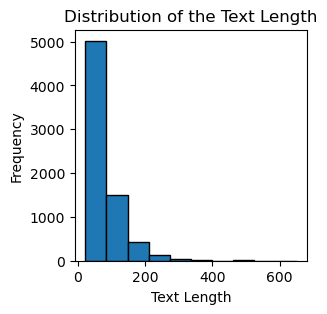

In [7]:
if not isSubmit:
    text_length = summary_df['text'].apply(lambda x: len(x.split(' ')))
    print(text_length.describe())
    print('\n')

    # Lets Visualize the same.
    from matplotlib import pyplot as plt

    # Create a histogram using Matplotlib
    plt.figure(figsize = (3, 3))
    plt.hist(text_length, bins=10, edgecolor='k')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of the Text Length')

The average text summary length is approximately 76 tokens, with a standard deviation of 54 tokens. Most of the text summaries have a length of less than 200 tokens. That is still in the limit of **BERT** and related models, which accept a **maximum of 512 tokens**. In Future, we might use some of the contextual information from the Prompt text to utilize this token gap properly.

Let's have an overall idea about the number of words (or tokens) in Prompt Text.

In [8]:
if not isSubmit:
    text_length = prompt_df['prompt_text'].apply(lambda x: len(x.split(' ')))
    # Lets Visualize the same.
    print(text_length)

0    604
1    550
2    597
3    966
Name: prompt_text, dtype: int64


Prompt Text is ranging from 550 to 966 words.

**We must provide this contextual information (prompt text) along with the text summary to yield better results.**

But this will result in a longer document (way longer than transformer can process --512 tokens--), to tackle this we will use longformer.

* Transformer-based models are unable to process long sequences due to their self-attention operation, which scales quadratically with the sequence length. To address this limitation, we introduce the Longformer with an attention mechanism that scales linearly with sequence length, making it easy to process documents of thousands of tokens or longer. 

we'll get back to this later if needed.

## Dataset and Dataloaders

Now Let's define the Dataset Class.

The Dataset class in Natural Language Processing (NLP) serves as a fundamental data structure that helps manage and handle textual data for training and evaluation purposes.

In [98]:
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class CommonLitSummaryDataset(Dataset):
    def __init__(self, 
                 summary_df,
                 prompt_df, 
                 tokz='/kaggle/input/commonlit-summaries-all-tokenizers/bert_base_cased_tokenizer', 
                 max_length = 256,
                 isTest = False,
                ):
        self.summary_df = summary_df
        self.prompt_df = prompt_df
        self.max_length = max_length
        self.tokz = AutoTokenizer.from_pretrained(tokz)
        self.isTest = isTest
        
    def __len__(self):
        return len(self.summary_df)
    
    def __getitem__(self, idx):
        
        # Get the Summary and It's Corresponding Question
        txt_summary = self.summary_df['text'].iloc[idx]
        prompt_id = self.summary_df['prompt_id'].iloc[idx]
        txt_question = self.prompt_df[self.prompt_df['prompt_id'] == prompt_id]['prompt_question'].iloc[0]
        title = self.prompt_df[self.prompt_df['prompt_id'] == prompt_id]['prompt_title'].iloc[0]
        
        # Concat the Question and Summary.
        # 'TITLE: ' + title + \
        input_text = ' QUESTION: ' + txt_question + ' SUMMARY: ' + txt_summary
        
        # Convert the text data into Corresponding Numerical Embeddings.
        encodings = self.tokz.encode_plus(input_text, 
                                          add_special_tokens=True, 
                                          max_length = self.max_length, 
                                          padding = 'max_length', 
                                          truncation = True, 
                                          return_tensors = 'pt'
                                         )
        input_ids = encodings['input_ids'].squeeze()
        attention_mask = encodings['attention_mask'].squeeze()
        
        # For Test set, No labels will be available
        if self.isTest:
            return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
            
        # Labels
        label = torch.tensor(self.summary_df.iloc[idx][-2:].tolist())
        
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

In [99]:
if not isSubmit:
    
    isStratified = True
    
    # Split the dataframe into train and validation sets
    from sklearn.model_selection import train_test_split
    
    if not isStratified:
        # Normal Split
        train_df, valid_df = train_test_split(summary_df, test_size=0.2, random_state=42)
    else:
        # Stratified Split
        test_prompt_id = ['3b9047']
        
        # Filter the DataFrame to create train and test sets
        train_df = summary_df[~summary_df['prompt_id'].isin(test_prompt_id)].reset_index(drop=True)
        valid_df = summary_df[summary_df['prompt_id'].isin(test_prompt_id)].reset_index(drop=True)

    
    print('Train Prompt IDs: ', train_df['prompt_id'].unique())
    print('Valid Prompt IDs: ', valid_df['prompt_id'].unique())

Train Prompt IDs:  ['814d6b' 'ebad26' '39c16e']
Valid Prompt IDs:  ['3b9047']


In [100]:
MAX_LENGTH = 256
TOKZ = "/kaggle/input/commonlit-summaries-all-tokenizers/deberta_base_v3_tokz/deberta_base_v3_tokz"

if not isSubmit:

    # Initialize Dataset Classes
    commonlit_summary_train_ds = CommonLitSummaryDataset(train_df,
                                                         prompt_df, 
                                                         tokz = TOKZ, 
                                                         max_length = MAX_LENGTH
                                                        )
    commonlit_summary_valid_ds = CommonLitSummaryDataset(valid_df, 
                                                         prompt_df,  
                                                         tokz = TOKZ,  
                                                         max_length = MAX_LENGTH
                                                        )
    print(f'Train - {len(commonlit_summary_train_ds)}, Test - {len(commonlit_summary_valid_ds)}')

Train - 5156, Test - 2009


Let's Visualize one Sample to see the working of our Dataset.

In [101]:
if not isSubmit:

    # Tokenizer
    tokz =  AutoTokenizer.from_pretrained(TOKZ)

    print(f'------ Input ----------\n')
    sample = commonlit_summary_train_ds[0]
    print(tokz.decode(sample['input_ids']))

    print(f'\n------ Labels ----------\n')
    labels = sample['labels']
    print(labels)

------ Input ----------

[CLS] QUESTION: Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. SUMMARY: The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

**Dataloader:**

Dataloader allows us to group multiple samples into batches, enabling parallel processing and more efficient GPU utilization during training.

In [102]:
# Dataloader
from torch.utils.data import DataLoader

if not isSubmit:
    # Create a data loader for the dataset
    batch_size = 16
    train_dataloader = DataLoader(commonlit_summary_train_ds, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(commonlit_summary_valid_ds, batch_size=batch_size, shuffle=False)

## Model Training

In [103]:
from transformers import AutoModelForSequenceClassification, AdamW

model_nm = 'microsoft/deberta-v3-base'
num_labels = 2

if not isSubmit:
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=num_labels)
    
    # Freeze Deberta Layers
    for param in model.deberta.parameters():
        param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\nTotal Trainable parameters: ", total_params)

    total_size = sum(p.numel() * p.element_size() for p in model.parameters())
    print("Total size (bytes) of the model: ", total_size)
    print("Total size (MB) of the model: ", total_size / (1024 * 1024))

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a


Total Trainable parameters:  592130
Total size (bytes) of the model:  737694728
Total size (MB) of the model:  703.5205154418945


we need to save the best model during Training based on the **MCRMSE** (mean columnwise root mean squared error) which is the Cost Function/ Metric for this Competition.

Let's implement this.

In [104]:
# Utility: mean columnwise root mean squared error
def mcrmse_loss(predictions, targets):
    rmse_columnwise = torch.sqrt(torch.mean((predictions - targets)**2, dim=0))
    return torch.mean(rmse_columnwise)

**Training Loop**

In order to have **faster Training**, we will do the followings:

1. **Enable mixed precision training** (using half-precision floating-point format or fp16). It utilizes Tensor Cores on supported NVIDIA GPUs to speed up the training process with reduced memory usage.

2.  To utilize Kaggle T4/X2 GPU, we will use **DataParallel**. DataParallel allows you to train your model on multiple GPUs simultaneously, distributing the workload across all available GPUs.

In [105]:
# Import Dataparallel and mixed precision modules
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
    
if not isSubmit:

    # Check if GPU is available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'DEVICE: {device}\n')

    # Used for Mixed Precision Training
    scaler = GradScaler()

    # Move your model to the GPU and wrap it with DataParallel (To utilize T4X2)
    model = model.to(device)
    model = DataParallel(model) 

DEVICE: cuda



Let's Train the Model.

In [52]:
# Visualize progress bar
from tqdm import tqdm
from transformers import AdamW

if not isSubmit:
    # Prepare optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)
    NUM_EPOCHS = 15

    best_eval_loss = float('inf')  # Initialize the best evaluation loss to infinity

    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        model.train() # Set the model to Training mode

        for batch in tqdm(train_dataloader):

            with autocast():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward loop
                optimizer.zero_grad() # Ensures Gradient doesn't accumulate.
                predictions = model(input_ids=input_ids,
                                    attention_mask=attention_mask, 
                                    labels=labels
                                   ).logits

                # Compute MCRMSE loss
                loss = mcrmse_loss(predictions, labels)

            # BackProp
            scaler.scale(loss).backward()  # Scale the loss value
            scaler.step(optimizer)
            scaler.update()

            # Accumulate the Loss
            total_loss += loss.item()

        # Calculate epoch-level metrics
        epoch_loss = total_loss / len(train_dataloader)

        # Print epoch-level metrics
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {epoch_loss:.4f}")

         # Evaluation
        model.eval()  # Set model to evaluation mode
        eval_loss = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                with autocast():
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    predictions = model(input_ids=input_ids,
                                        attention_mask=attention_mask, 
                                        labels=labels
                                       ).logits
                    loss = mcrmse_loss(predictions, labels)

                    eval_loss += loss.item()

        # Calculate evaluation metrics
        eval_epoch_loss = eval_loss / len(eval_dataloader)

        # Print evaluation metrics
        print(f"Eval Loss: {eval_epoch_loss:.4f}")

        # Save the Best Model
        if eval_epoch_loss < best_eval_loss:
            print(f'--------------------------------------')
            print(f'Found the best model at Epoch {epoch+1}')
            print(f'Validation Loss reduced from {best_eval_loss:.4f} to {eval_epoch_loss:.4f}')
            best_eval_loss = eval_epoch_loss
            print(f'Saving the best model.')
            print(f'--------------------------------------\n')
            
            # Access the actual model from the DataParallel object
            actual_model = model.module
            # Save
            actual_model.save_pretrained("debertaBaseV3_3b9047")

100%|██████████| 323/323 [01:33<00:00,  3.47it/s]


Epoch 1/15
Train Loss: 0.8622
Eval Loss: 0.7415
--------------------------------------
Found the best model at Epoch 1
Validation Loss reduced from inf to 0.7415
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:35<00:00,  3.40it/s]


Epoch 2/15
Train Loss: 0.7657
Eval Loss: 0.6959
--------------------------------------
Found the best model at Epoch 2
Validation Loss reduced from 0.7415 to 0.6959
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:35<00:00,  3.38it/s]


Epoch 3/15
Train Loss: 0.7315
Eval Loss: 0.7553


100%|██████████| 323/323 [01:33<00:00,  3.47it/s]


Epoch 4/15
Train Loss: 0.7068
Eval Loss: 0.6619
--------------------------------------
Found the best model at Epoch 4
Validation Loss reduced from 0.6959 to 0.6619
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 5/15
Train Loss: 0.6963
Eval Loss: 0.9148


100%|██████████| 323/323 [01:34<00:00,  3.41it/s]


Epoch 6/15
Train Loss: 0.6910
Eval Loss: 0.6495
--------------------------------------
Found the best model at Epoch 6
Validation Loss reduced from 0.6619 to 0.6495
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:35<00:00,  3.38it/s]


Epoch 7/15
Train Loss: 0.6770
Eval Loss: 0.6505


100%|██████████| 323/323 [01:33<00:00,  3.44it/s]


Epoch 8/15
Train Loss: 0.6736
Eval Loss: 0.6544


100%|██████████| 323/323 [01:34<00:00,  3.42it/s]


Epoch 9/15
Train Loss: 0.6703
Eval Loss: 0.8404


100%|██████████| 323/323 [01:35<00:00,  3.38it/s]


Epoch 10/15
Train Loss: 0.6600
Eval Loss: 0.7220


100%|██████████| 323/323 [01:36<00:00,  3.36it/s]


Epoch 11/15
Train Loss: 0.6619
Eval Loss: 0.6737


100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 12/15
Train Loss: 0.6600
Eval Loss: 0.6483
--------------------------------------
Found the best model at Epoch 12
Validation Loss reduced from 0.6495 to 0.6483
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:36<00:00,  3.36it/s]


Epoch 13/15
Train Loss: 0.6584
Eval Loss: 0.7328


100%|██████████| 323/323 [01:33<00:00,  3.46it/s]


Epoch 14/15
Train Loss: 0.6569
Eval Loss: 0.6339
--------------------------------------
Found the best model at Epoch 14
Validation Loss reduced from 0.6483 to 0.6339
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:32<00:00,  3.47it/s]


Epoch 15/15
Train Loss: 0.6590
Eval Loss: 0.6552


**Progressive Unfreezing**

In [106]:
# Visualize progress bar
from tqdm import tqdm
from transformers import AdamW

if not isSubmit:
    
    # Prepare optimizer
    LR_RATE = 3e-4
    LR_DECAY = 0.1
    optimizer = AdamW(model.parameters(), lr=LR_RATE)
    NUM_EPOCHS = 25
    EPOCH_STEPS = [11, 16, 21]
    
    best_eval_loss = float('inf')  # Initialize the best evaluation loss to infinity
    
    STEP = 2
    for epoch in range(NUM_EPOCHS):
        
        # Progressive Unfreezing
        if epoch == EPOCH_STEPS[2-STEP]:
            print(f'-------------------Progressive Unfreezing-------------------------------------\n')
            print(f'Unfreezing Encoder Layers {4*STEP} to {4*STEP + 4}')
            for param in model.module.deberta.encoder.layer[4*STEP:4*STEP + 4].parameters():
                param.requires_grad = True

            total_params = sum(p.numel() for p in model.module.parameters() if p.requires_grad)
            print("\nTotal Trainable parameters: ", total_params)
            print(f'Lowering the Learning Rate...')
            LR_RATE = LR_RATE *  LR_DECAY
            print(f'Updating the Optimizer with new learning rate of {LR_RATE}')
            optimizer = AdamW(model.parameters(), lr=LR_RATE)
            STEP = STEP - 1
            print(f'--------------------------------------------------------------------------------\n')

        total_loss = 0
        model.train() # Set the model to Training mode

        for batch in tqdm(train_dataloader):

            with autocast():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward loop
                optimizer.zero_grad() # Ensures Gradient doesn't accumulate.
                predictions = model(input_ids=input_ids,
                                    attention_mask=attention_mask, 
                                    labels=labels
                                   ).logits

                # Compute MCRMSE loss
                loss = mcrmse_loss(predictions, labels)

            # BackProp
            scaler.scale(loss).backward()  # Scale the loss value
            scaler.step(optimizer)
            scaler.update()

            # Accumulate the Loss
            total_loss += loss.item()

        # Calculate epoch-level metrics
        epoch_loss = total_loss / len(train_dataloader)

        # Print epoch-level metrics
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {epoch_loss:.4f}")

         # Evaluation
        model.eval()  # Set model to evaluation mode
        eval_loss = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                with autocast():
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    predictions = model(input_ids=input_ids,
                                        attention_mask=attention_mask, 
                                        labels=labels
                                       ).logits
                    loss = mcrmse_loss(predictions, labels)

                    eval_loss += loss.item()

        # Calculate evaluation metrics
        eval_epoch_loss = eval_loss / len(eval_dataloader)

        # Print evaluation metrics
        print(f"Eval Loss: {eval_epoch_loss:.4f}")

        # Save the Best Model
        if eval_epoch_loss < best_eval_loss:
            print(f'--------------------------------------')
            print(f'Found the best model at Epoch {epoch+1}')
            print(f'Validation Loss reduced from {best_eval_loss:.4f} to {eval_epoch_loss:.4f}')
            best_eval_loss = eval_epoch_loss
            print(f'Saving the best model.')
            print(f'--------------------------------------\n')
            
            # Access the actual model from the DataParallel object
            actual_model = model.module
            # Save
            actual_model.save_pretrained("debertaBaseV3_3b9047")

100%|██████████| 323/323 [01:34<00:00,  3.42it/s]


Epoch 1/25
Train Loss: 0.8801
Eval Loss: 0.7506
--------------------------------------
Found the best model at Epoch 1
Validation Loss reduced from inf to 0.7506
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.44it/s]


Epoch 2/25
Train Loss: 0.7647
Eval Loss: 0.7065
--------------------------------------
Found the best model at Epoch 2
Validation Loss reduced from 0.7506 to 0.7065
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 3/25
Train Loss: 0.7303
Eval Loss: 0.6863
--------------------------------------
Found the best model at Epoch 3
Validation Loss reduced from 0.7065 to 0.6863
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 4/25
Train Loss: 0.7139
Eval Loss: 0.6941


100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 5/25
Train Loss: 0.6870
Eval Loss: 0.6667
--------------------------------------
Found the best model at Epoch 5
Validation Loss reduced from 0.6863 to 0.6667
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 6/25
Train Loss: 0.6777
Eval Loss: 0.6627
--------------------------------------
Found the best model at Epoch 6
Validation Loss reduced from 0.6667 to 0.6627
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:32<00:00,  3.48it/s]


Epoch 7/25
Train Loss: 0.6745
Eval Loss: 0.6689


100%|██████████| 323/323 [01:33<00:00,  3.46it/s]


Epoch 8/25
Train Loss: 0.6761
Eval Loss: 0.6481
--------------------------------------
Found the best model at Epoch 8
Validation Loss reduced from 0.6627 to 0.6481
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 9/25
Train Loss: 0.6729
Eval Loss: 0.6892


100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 10/25
Train Loss: 0.6628
Eval Loss: 0.6644


100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Epoch 11/25
Train Loss: 0.6571
Eval Loss: 0.6482
-------------------Progressive Unfreezing-------------------------------------

Unfreezing Encoder Layers 8 to 12

Total Trainable parameters:  28943618
Lowering the Learning Rate...
Updating the Optimizer with new learning rate of 2.9999999999999997e-05
--------------------------------------------------------------------------------



100%|██████████| 323/323 [01:47<00:00,  3.02it/s]


Epoch 12/25
Train Loss: 0.5702
Eval Loss: 0.6376
--------------------------------------
Found the best model at Epoch 12
Validation Loss reduced from 0.6481 to 0.6376
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:47<00:00,  3.00it/s]


Epoch 13/25
Train Loss: 0.4991
Eval Loss: 0.6525


100%|██████████| 323/323 [01:46<00:00,  3.02it/s]


Epoch 14/25
Train Loss: 0.4703
Eval Loss: 0.8572


100%|██████████| 323/323 [01:46<00:00,  3.02it/s]


Epoch 15/25
Train Loss: 0.4412
Eval Loss: 0.6144
--------------------------------------
Found the best model at Epoch 15
Validation Loss reduced from 0.6376 to 0.6144
Saving the best model.
--------------------------------------



100%|██████████| 323/323 [01:47<00:00,  3.01it/s]


Epoch 16/25
Train Loss: 0.4294
Eval Loss: 0.6471
-------------------Progressive Unfreezing-------------------------------------

Unfreezing Encoder Layers 4 to 8

Total Trainable parameters:  57295106
Lowering the Learning Rate...
Updating the Optimizer with new learning rate of 3e-06
--------------------------------------------------------------------------------



100%|██████████| 323/323 [02:01<00:00,  2.66it/s]


Epoch 17/25
Train Loss: 0.3698
Eval Loss: 0.6420


100%|██████████| 323/323 [02:00<00:00,  2.68it/s]


Epoch 18/25
Train Loss: 0.3545
Eval Loss: 0.6237


100%|██████████| 323/323 [02:01<00:00,  2.66it/s]


Epoch 19/25
Train Loss: 0.3471
Eval Loss: 0.6616


100%|██████████| 323/323 [02:00<00:00,  2.68it/s]


Epoch 20/25
Train Loss: 0.3374
Eval Loss: 0.6436


100%|██████████| 323/323 [02:00<00:00,  2.67it/s]


Epoch 21/25
Train Loss: 0.3302
Eval Loss: 0.6464
-------------------Progressive Unfreezing-------------------------------------

Unfreezing Encoder Layers 0 to 4

Total Trainable parameters:  85646594
Lowering the Learning Rate...
Updating the Optimizer with new learning rate of 3.0000000000000004e-07
--------------------------------------------------------------------------------



100%|██████████| 323/323 [02:15<00:00,  2.38it/s]


Epoch 22/25
Train Loss: 0.3204
Eval Loss: 0.6441


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│    17 │   for epoch in range(NUM_EPOCHS):                                                        │
│    18 │   │                                                                                      │
│    19 │   │   # Progressive Unfreezing                                                           │
│ ❱  20 │   │   if epoch == EPOCH_STEPS[2-STEP]:                                                   │
│    21 │   │   │   print(f'-------------------Progressive Unfreezing---------------------------   │
│    22 │   │   │   print(f'Unfreezing Encoder Layers {4*STEP} to {4*STEP + 4}')                   │
│    23 │   │   │   for param in model.module.deberta.encoder.layer[4*STEP:4*STEP + 4].parameter   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

## Model Inference

Prepare Test Data Loader.

In [87]:
MAX_LENGTH = 256
TOKZ = "/kaggle/input/commonlit-summaries-all-tokenizers/deberta_base_v3_tokz/deberta_base_v3_tokz"

# Read Test DF's.
prompt_test_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
summary_test_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

# Initialize Dataset Classes
commonlit_summary_test_ds = CommonLitSummaryDataset(summary_test_df,
                                                    prompt_test_df, 
                                                    tokz = TOKZ, 
                                                    max_length = MAX_LENGTH,
                                                    isTest = True
                                                    )
# Test Dataloader
batch_size = 16
test_loader = DataLoader(commonlit_summary_test_ds, batch_size=batch_size, shuffle=False)

test_loader

**Prediction**

In [88]:
# Variable to set True for 4-Fold Inference.
isKFold = False

**For a Single Fold Model Inference.**

In [89]:
# Eval model
if not isKFold:
    
    # Load Model
    model_path = '/kaggle/input/commonlit-summaries-all-models/deberta_base_v3/deberta_base_v3/39c16e'
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Check if GPU is available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'DEVICE: {device}\n')

    # Model to the Device
    model = model.to(device)
    model = DataParallel(model) 
    model.eval()

    predictions = []
    with torch.no_grad():  # Disable gradient computation during inference
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Predictions
            predictions_batch = model(input_ids=input_ids,
                                      attention_mask=attention_mask
                                     ).logits

            # Collect predictions from this batch
            predictions.extend(predictions_batch.cpu().tolist())


    # Convert to numpy
    import numpy as np
    predictions = np.array(predictions)

**For 4-Fold Model Inference**

In [90]:
if isKFold:
    
    import numpy as np
    # Check if GPU is available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'DEVICE: {device}\n')
    
    # Provide the List of all model paths.
    model_paths = ['/kaggle/input/commonlit-summaries-all-models/deberta_base_v3/deberta_base_v3/39c16e', 
                   '/kaggle/input/commonlit-summaries-all-models/deberta_base_v3/deberta_base_v3/3b9047', 
                   '/kaggle/input/commonlit-summaries-all-models/deberta_base_v3/deberta_base_v3/814d6b', 
                   '/kaggle/input/commonlit-summaries-all-models/deberta_base_v3/deberta_base_v3/ebad26'
                  ]
    
    # 4-Fold Predictions
    fold_4_predictions = []
    
    # Predictions
    for path in model_paths:
        stratified_id = path.split('/')[-1]
        print(f'Fold-ID: {stratified_id}')
        model = AutoModelForSequenceClassification.from_pretrained(path)
        model = model.to(device)
        model = DataParallel(model) 
        model.eval()

        predictions = []
        with torch.no_grad():  # Disable gradient computation during inference
            for batch in tqdm(test_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                # Predictions
                predictions_batch = model(input_ids=input_ids,
                                          attention_mask=attention_mask
                                         ).logits

                # Collect predictions from this batch
                predictions.extend(predictions_batch.cpu().tolist())
        
        # Append
        fold_4_predictions.append(predictions)
        
    # Predictions    
    predictions = np.mean(np.array(fold_4_predictions), axis=0) 

DEVICE: cuda

Fold-ID: 39c16e


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Fold-ID: 3b9047


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Fold-ID: 814d6b


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Fold-ID: ebad26


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


**Submission**

In [91]:
# Create a DataFrame
data = {
    'student_id': summary_test_df['student_id'].tolist(),
    'content': predictions[:,0],
    'wording': predictions[:,1]
}
submission_df = pd.DataFrame(data)

# Display
display(submission_df.head())

# Save it for Submission
submission_df.to_csv('submission.csv', index=False)

,student_id,content,wording
0,000000ffffff,-1.544345,-1.197182
1,111111eeeeee,-1.544267,-1.198148
2,222222cccccc,-1.544800,-1.195079
3,333333dddddd,-1.542942,-1.194006


## Model Performance Tracker

**1. Bert-Base-Cased**

<style>
table {
    width: 100%;
    border-collapse: collapse;
}

th, td {
    padding: 8px;
    text-align: left;
}

th {
    background-color: #FF0000; /* Red color */
    color: white;
}
</style>

<table>
    <tr>
        <th><span style="color:red">S.No.</span></th>
        <th><span style="color:red">Seed/ID</span></th>
        <th><span style="color:red">Split</span></th>
        <th><span style="color:red">Model_name</span></th>
        <th><span style="color:red">Input Tokens</span></th>
        <th><span style="color:red">CV</span></th>
        <th><span style="color:red">LB</span></th>
    </tr>
    <tr>
        <td>1</td>
        <td>3b9047</td>
        <td>Stratify</td>
        <td>bert-base-cased</td>
        <td>256</td>
        <td>0.6537</td>
        <td>0.544</td>
    </tr>
    <tr>
        <td>2</td>
        <td>814d6b</td>
        <td>Stratify</td>
        <td>bert-base-cased</td>
        <td>256</td>
        <td>0.6895</td>
        <td>0.566</td>
    </tr>
    <tr>
        <td>3</td>
        <td>ebad26</td>
        <td>Stratify</td>
        <td>bert-base-cased</td>
        <td>256</td>
        <td>0.5605</td>
        <td>0.547</td>
    </tr>
    <tr>
        <td>4</td>
        <td>39c16e</td>
        <td>Stratify</td>
        <td>bert-base-cased</td>
        <td>256</td>
        <td>0.5567</td>
        <td>0.603</td>
    </tr>
    <tr style="background-color: lightgreen;">
        <td>5</td>
        <td>4-Fold</td>
        <td>Stratify</td>
        <td>bert-base-cased</td>
        <td>256</td>
        <td>NA</td>
        <td>0.530</td>
    </tr>
 
    
</table>



**2. Deberta-base-v3**

<style>
table {
    width: 100%;
    border-collapse: collapse;
}

th, td {
    padding: 8px;
    text-align: left;
}

th {
    background-color: #FF0000; /* Red color */
    color: white;
}
</style>

<table>
    <tr>
        <th><span style="color:red">S.No.</span></th>
        <th><span style="color:red">Seed/ID</span></th>
        <th><span style="color:red">Split</span></th>
        <th><span style="color:red">Model_name</span></th>
        <th><span style="color:red">Input Tokens</span></th>
        <th><span style="color:red">CV</span></th>
        <th><span style="color:red">LB</span></th>
    </tr>
    <tr>
        <td>1</td>
        <td>3b9047</td>
        <td>Stratify</td>
        <td>deberta-base-v3</td>
        <td>256</td>
        <td>0.6020</td>
        <td>0.516</td>
    </tr>
    <tr>
        <td>2</td>
        <td>814d6b</td>
        <td>Stratify</td>
        <td>deberta-base-v3</td>
        <td>256</td>
        <td>0.5697</td>
        <td>0.526</td>
    </tr>
    <tr>
        <td>3</td>
        <td>ebad26</td>
        <td>Stratify</td>
        <td>deberta-base-v3</td>
        <td>256</td>
        <td>0.4932</td>
        <td>0.525</td>
    </tr>
    <tr>
        <td>4</td>
        <td>39c16e</td>
        <td>Stratify</td>
        <td>deberta-base-v3</td>
        <td>256</td>
        <td>0.4729</td>
        <td>0.502</td>
    </tr>
        <tr style="background-color: lightgreen;">
        <td>5</td>
        <td>4-Fold</td>
        <td>Stratify</td>
        <td>deberta-base-v3</td>
        <td>256</td>
        <td>NA</td>
        <td>0.495</td>
    </tr>
    
</table>



**TODO:**

* FP16 Training <font color="green">&#10004;</font>
* Utilize Both of the GPU's <font color="green">&#10004;</font>
* Stratified Split <font color="green">&#10004;</font>
* Data Augmentation - CutMix, Back Translation <font color="green">&#10004;</font> (--**Did NOT worked**--)
* CommonLit MLM Training --> Downstream Task  <font color="green">&#10004;</font> (--**Did NOT worked**--)
* Model Architecture Tweaking <font color="green">&#10004;</font>
* Freeze Top-n Layers
* Learning Rate Schedular
* Pseudo Labeling
* Experiment with the Loss Function.
* Analyse content and wording score separately.
* Evaluation on Steps rather than Epochs.
* Try Deberta-v3-base + SiFT
* Experiment with the MAX_LENGTH. (Try 512)